# import install

A Fast, Extensible Progress Bar for Python
https://github.com/tqdm/tqdm

In [481]:
# !pip install tqdm

Industrial-Strength Natural Language Processing (NLP)
https://spacy.io/

In [482]:
# !pip install spacy==2.3.7

In [483]:
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz 

Language detection library
ported from Google's language-detection.
https://pypi.org/project/langdetect/

In [484]:
# !pip install langdetect

# Exploration

In [485]:
import sys
sys.path.append('../library/')
# Own library

import json
import os
import pandas as pd
from matplotlib import pyplot as plt

# data loading

get all file in data folder, and load in a dataframe

In [527]:
articlesPath = os.listdir("data")
len(articlesPath)

3163

In [528]:
# reload previous processed dataframe

df_processed = pd.read_pickle('./processedDF.pkl') 
len(df_processed)

2727

In [529]:
len(articlesPath) - len(df_processed)

436

In [530]:
# create dataframe for NLP with only new article or empty

df = pd.DataFrame(columns=['PMID', 'body'])

s = pd.Series(df_processed['PMID']).unique()

for i in articlesPath:
    if (i.replace('.json', '').strip() in s) == False :
      with open(f'data/{i}') as f:
          test = json.loads(f.read())
      df = df.append(
          {'PMID': test['PMID'], 'body': test['body']}, ignore_index=True)


df.head()


,PMID,body
0,1,
1,10024467,
2,10075709,
3,10199401,
4,10384301,


# cleaning data

In [531]:
df.drop(df[df['body'].map(len) == 0].index, inplace=True) # delete where body is an empty array
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   PMID    0 non-null      object
 1   body    0 non-null      object
dtypes: object(2)
memory usage: 0.0+ bytes


# Article language

## with abstract

In [491]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['body'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 103/103 [00:03<00:00, 26.66it/s]


In [492]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
print(languages_dict)

Total: 103

{'en': 103}


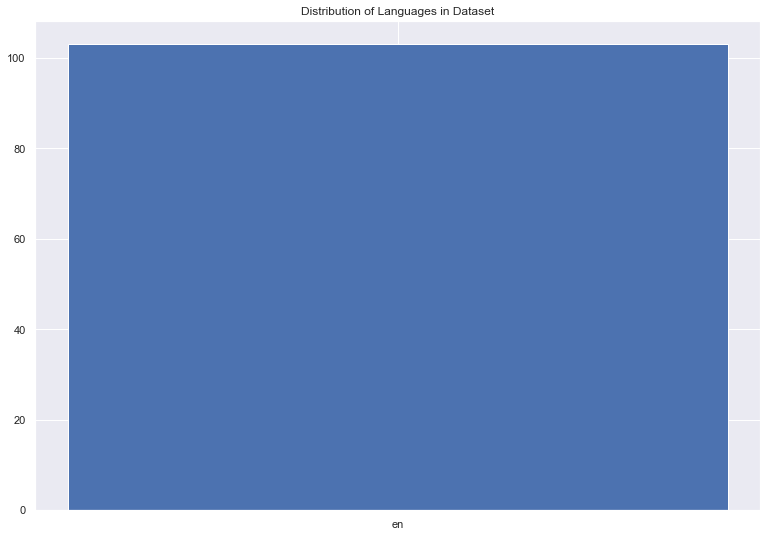

In [493]:
df['language'] = languages

inter_len = 645

plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

# NLP


In [494]:
import string
from spacy.lang.en.stop_words import STOP_WORDS

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['his',
 'thru',
 'did',
 'whole',
 'front',
 'nevertheless',
 'during',
 'third',
 'within',
 'much']

In [495]:
# Add to stopword some customs:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [496]:
# en_core_sci_lg  => https://allenai.github.io/scispacy/
# A full spaCy pipeline for biomedical data with a larger vocabulary and 600k word vectors.

import en_core_sci_lg

parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

C:\Users\rouxa\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_sci_lg' (0.2.4) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.7). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [497]:
import spacy

In [498]:
from tqdm import tqdm
tqdm.pandas() #to display progress bar
df["processed_abstract"] = df["body"].progress_apply(spacy_tokenizer)

100%|██████████| 103/103 [01:30<00:00,  1.14it/s]


In [499]:
df.head()

,PMID,body,language,processed_abstract
28,12060738,AbstractLarge-scale genomics has enabled prot...,en,abstractlarge-scale genomics enable proteomics...
36,12643522,AbstractThe components of complex peptide mix...,en,abstractthe component complex peptide mixture ...
66,16533169,AbstractRORγ2 (retinoid-related orphan recept...,en,abstractrorγ2 retinoid-related orphan receptor...
86,17101441,AbstractMass spectrometry based approaches ar...,en,abstractmass spectrometry base approach common...
87,17138671,AbstractComponents of multiprotein complexes ...,en,abstractcomponents multiprotein complex routin...


In [500]:
# Store df after nlp

df = pd.concat([df, df_processed])


In [501]:
len(df)

2727

In [502]:

df.to_pickle('./processedDF.pkl')

# Vectorization

In [503]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [504]:
text = df['processed_abstract'].values
max_features = 2**12

X = vectorize(text, max_features)

# PCA  & Clustering

Let's see how much we can reduce the dimensions while still keeping 95% variance. We will apply Principle Component Analysis (PCA) to our vectorized data. This will reduce the complexity of our dimensionality reduction step and filter noise.

In [505]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(2727, 1062)

To separate the literature, k-means will be run on the vectorized text. Given the number of clusters, k, k-means will categorize each vector by taking the mean distance to a randomly initialized centroid. The centroids are updated iteratively.

In [506]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

### How many clusters? 

To find the best k value for k-means we'll look at the distortion at different k values. Distortion computes the sum of squared distances from each point to its assigned center. When distortion is plotted against k there will be a k value after which decreases in distortion are minimal. This is the desired number of clusters.

In [507]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np  # linear algebra

# run kmeans with many different k
distortions = []
K = range(10, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print('Found distortion for {} clusters'.format(k))

Found distortion for 10 clusters
Found distortion for 11 clusters
Found distortion for 12 clusters
Found distortion for 13 clusters
Found distortion for 14 clusters
Found distortion for 15 clusters
Found distortion for 16 clusters
Found distortion for 17 clusters
Found distortion for 18 clusters
Found distortion for 19 clusters
Found distortion for 20 clusters
Found distortion for 21 clusters
Found distortion for 22 clusters
Found distortion for 23 clusters
Found distortion for 24 clusters
Found distortion for 25 clusters
Found distortion for 26 clusters
Found distortion for 27 clusters
Found distortion for 28 clusters
Found distortion for 29 clusters


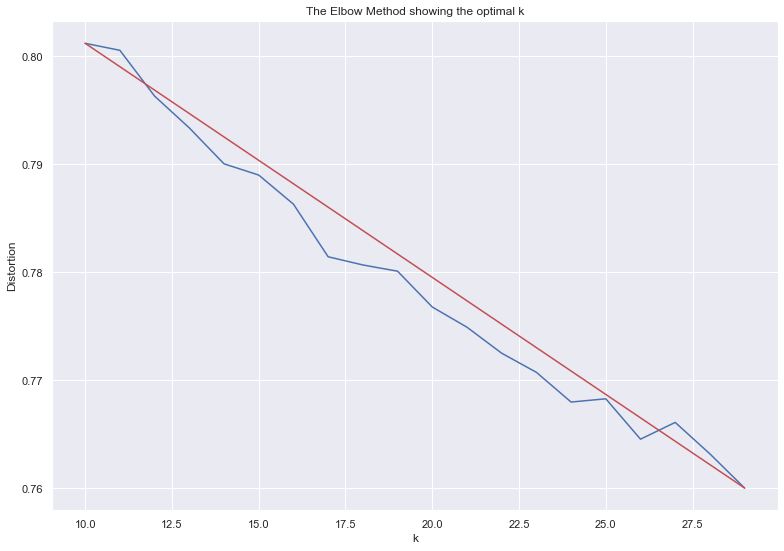

In [508]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Run k-means

In [509]:
k = 21
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

# Dimensionality Reduction with t-SNE

Using [t-SNE](https://lvdmaaten.github.io/tsne) we can reduce our high dimensional features vector to 2 dimensions. By using the 2 dimensions as x,y coordinates, the body_text can be plotted. t-SNE will attempt to preserve the relations of the higher dimensional data as closely as possible when shrunk to 2D. The similar article will thus be in closer proximity to each other.

In [510]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=100)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2727 samples in 0.026s...
[t-SNE] Computed neighbors for 2727 samples in 0.841s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2727
[t-SNE] Computed conditional probabilities for sample 2000 / 2727
[t-SNE] Computed conditional probabilities for sample 2727 / 2727
[t-SNE] Mean sigma: 0.360828
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.777805
[t-SNE] KL divergence after 1000 iterations: 1.141911


C:\Users\rouxa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


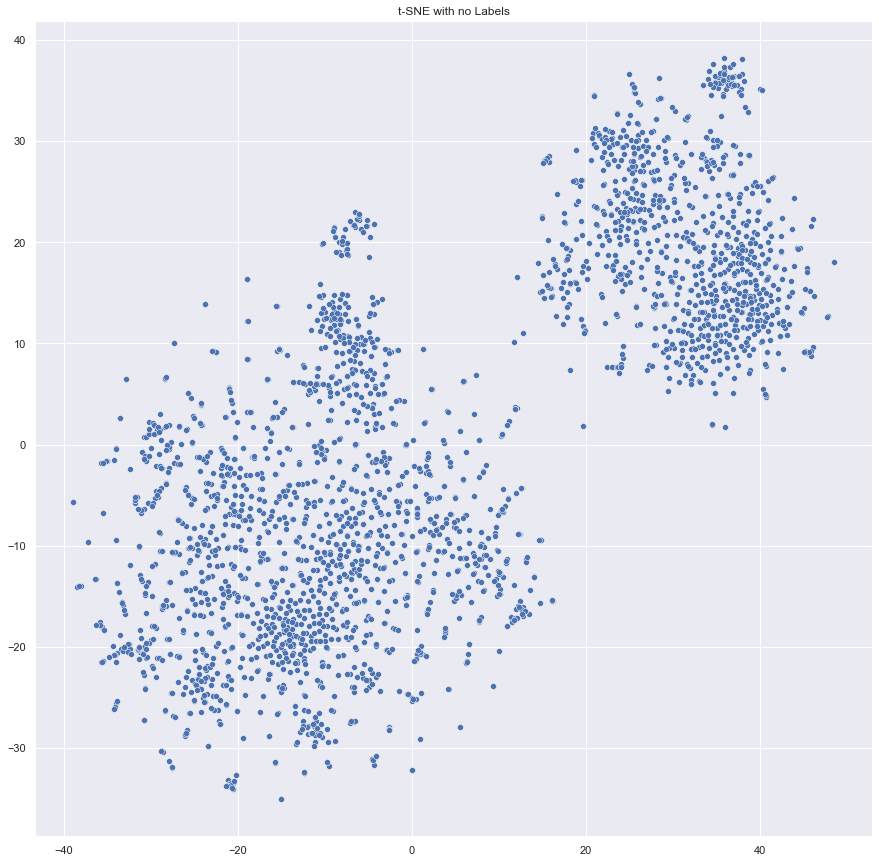

In [511]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

C:\Users\rouxa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


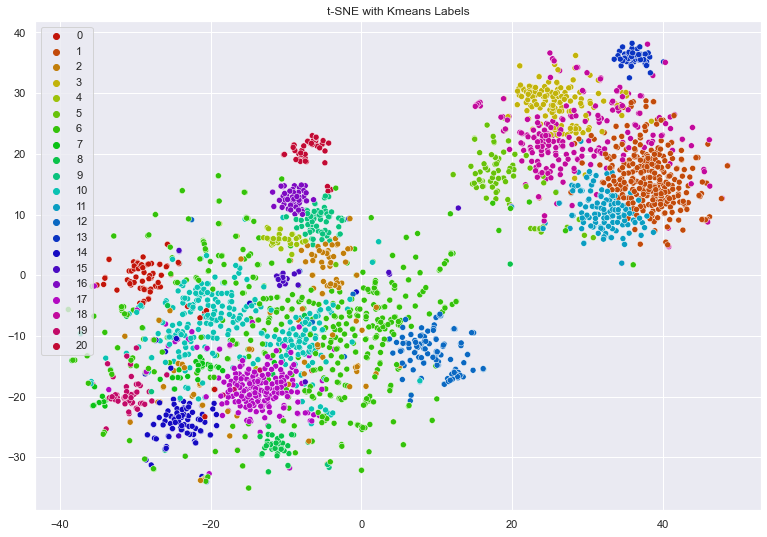

In [512]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

The labeled plot gives better insight into how the papers are grouped. Interestingly, both k-means and t-SNE can find independent clusters even though they were run independently. This shows that structure within the literature can be observed and measured to some extent. 

Now there are other cases where the colored labels are spread out on the plot. This is a result of t-SNE and k-means finding different connections in the higher dimensional data. The topics of these papers often intersect so it was hard to cleanly separate them. 

# Topic Modeling on Each Cluster

Now we will attempt to find the most significant words in each cluster. K-means clustered the articles but did not label the topics. Through topic modeling, we will find out what the most important terms for each cluster are. This will add more meaning to the cluster by giving keywords to quickly identify the themes of the cluster.

For topic modeling, we will use LDA (Latent Dirichlet Allocation). In LDA, each document can be described by a distribution of topics and each topic can be described by a distribution of words[.](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

In [513]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [514]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/1276/0*Sj65xR38wDwuxhtr.jpg', width=800, height=800)

In [515]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [516]:
vectorizers[0]

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}')

In [517]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_abstract']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [518]:
len(vectorized_data)

20

Topic modeling will be performed through the use of Latent Dirichlet Allocation (LDA). This is a generative statistical model that allows sets of words to be explained by a shared topic

In [519]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20


lda_models = []

for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

For each cluster, we had created a corresponding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [520]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


Extracts the keywords from each cluster

In [521]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

Append list of keywords for a single cluster to 2D list of length NUM_TOPICS_PER_CLUSTER

In [522]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [523]:
all_keywords[0][:10]

['coilin',
 'position',
 'cross-link',
 'dis',
 'lane',
 'export',
 'transcript',
 'trf',
 'tbp',
 'promoter']

In [524]:
len(all_keywords)

20

### Save current outputs to file

Re-running some parts of the notebook (especially vectorization and t-SNE) are time-intensive tasks. We want to make sure that the important outputs for generating the bokeh plot are saved for future use.

In [525]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [526]:
# import pickle

# # save the COVID-19 DataFrame
# pickle.dump(df, open("df_art.p", "wb" ))

# # save the final t-SNE
# pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# # save the labels generate with k-means(20)
# pickle.dump(y_pred, open("y_pred.p", "wb" ))